# Kronecker Graph Notebook

This notebook is based off "[Kronecker Graphs: An Approach to Modeling Network" by Leskovec et al](http://www.jmlr.org/papers/v11/leskovec10a.html).

## Setup

In [1]:
import numpy as np
import torch
import networkx as nx
import time
from tqdm.notebook import tqdm

#import jax.numpy as np
#from jax import random
#key = random.PRNGKey(0)

## matplotlib and plot settings
import matplotlib
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.style as style 

style.use('seaborn-paper')
fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'lines.linewidth': 2
                    },
                   )

### load the dataset

https://snap.stanford.edu/data/cit-HepTh.html

In [2]:
edgelist = np.loadtxt('../data/Cit-HepTh.txt', dtype=np.int)
np.savetxt('../data/Cit-HepTh_processed.txt', edgelist, fmt='%i', delimiter=' ')

In [3]:
G_directed = nx.read_edgelist('../data/Cit-HepTh_processed.txt', create_using=nx.DiGraph())
G_undirected = nx.to_undirected(G_directed)

### Compute some graph statistics

Use the undirected graph. These don't quite match the statistics listed on the dataset's webpage...

In [4]:
print('number of nodes: %i' %G_undirected.number_of_nodes())
print('number of edges: %i' %G_undirected.number_of_edges())
print('average clustering coefficient: %.2f' %nx.average_clustering(G_undirected))
print('number of triangles: %.2f' %(len(nx.triangles(G_undirected))/3))
print('transitivity: %.2f' %(nx.transitivity(G_undirected)))

number of nodes: 27770
number of edges: 352826
average clustering coefficient: 0.31
number of triangles: 9256.67
transitivity: 0.12


In [4]:
## get the adjacency matrix
adj_undirected = nx.adjacency_matrix(G_undirected)
adj_undirected = adj_undirected.todense()
adj_undirected_torch = torch.from_numpy(adj_undirected).double()

In [5]:
print('sparsity of Aij: %.2e' %np.mean(adj_undirected))

sparsity of Aij: 9.14e-04


In [7]:
## get the largest connected component (LCC)
G_undirected_LCC = G_undirected.subgraph(sorted(nx.connected_components(G_undirected), key=len, reverse=True)[0])
#nx.diameter(G_undirected_LCC) this takes an awfully long time

$$ \tilde{P}_1 = \phi(W_L P_1 W_R) $$ 

- hold permutations constant / canonical ordering
- how to incorporate adversarial learning
- consider generalizing Pk to include more parameters

## Theoretical Background

### Loss function
In the Kronecker Graph Model, the probability of edge $(i,j)$ being present in the generated graph is

$$ P[(i,j) \in G | \sigma] = (P_k)_{ij} \,. $$

Here $P_k$ is the stochastic Kronecker matrix generated by raising the initial seed matrix to the $k$-th power (i.e. multiplying $P_1$ with $k$ copies of itself using the Kronecker product):

$$ P_k(P_1) = \underbrace{P_1 \otimes P_1 ... \otimes P_1}_k \,.$$

Then, given either $P_k$ or $P_1$, as well as a node ordering (or permutation) $\sigma$, the conditional probability of observing the "data" graph $G$ is

$$ \ln P(G|P_k, \sigma) = \sum_{i,j} \Big[ A_{ij} \ln \left( (P_k)_{\sigma(i) \sigma(j)} \right) + (1-A_{ij}) \left( (1-(P_k)_{\sigma(i) \sigma(j)})) \right) \Big] \,. $$

Here $A_{ij}$ is the adjacency matrix for $G$. Note that the permutation only applies to the indices of $P_k$, and not $A$. Thus, conditioned on $P_k, \sigma$, each edge in the graph is modeled as an independent Bernoulli variable. Because $P_k$ and $P_1$ are deterministically related to one another, we can just as easily regard $P_k$ as a function of $P_1$ and write the same expression for $P(G|P_1, \sigma)$. Also, note that the above expression is just the negative binary cross entropy (BCE). Another thing to note it that it could alternatively be written in terms of the inverse permutation as:

$$ \ln P(G|P_k, \sigma) = \sum_{i,j} \Big[ A_{\sigma^{-1}(i) \sigma^{-1}(j)} \ln \left( (P_k)_{ij} \right) + (1-A_{\sigma^{-1}(i) \sigma^{-1}(j)}) \left( (1-(P_k)_{ij}) \right) \Big] \,. $$

The model can be trained by maximizing the log likelihood $\ln P(G|P_1) = \ln P(G|P_k)$. To obtain this expression we need to sum over all permutations:

$$ \ln P(G|P_1) = \ln \left( \sum_{\sigma} P(G|P_1, \sigma) P(\sigma) \right) \,. $$

Unfortunately, this sum is intractable as there are $N!$ permutations. To surmount this obstacle, we will turn to Monte Carlo sampling. Before doing so, let's first write the gradient of this in a suggestive form:

$$ \nabla_{P_1} \ln P(G|P_1) = \sum_{\sigma} P(\sigma|G, P_1) \nabla_{P_1} \ln P(G|P_1, \sigma) = \mathbb{E}_{\sigma \sim P(\sigma|G, P_1)} \nabla_{P_1} \ln P(G|P_1, \sigma) \,. $$

### MCMC sampling

Our task is to build a Markov Chain to sample $P(\sigma|G, P_1)$ so that we can estimate the sum in the above expression. Let's rewrite this as 

$$ P(\sigma|G, P_1) = \frac{P(G, P_1, \sigma)}{P(G, P_1)} = \frac{P(G|P_1, \sigma) P(P_1, \sigma)}{P(G, P_1)} \,.$$

If we furthermore assume that 
1. $P_1$ and $\sigma$ are independent, i.e. $P(P_1, \sigma) = P(P_1) P(\sigma)$
2. we pick the uniform distribution over all permutations, so that $P(\sigma) = 1/N!$

then for two different permutations $\sigma, \tau$ we have the following nice relation

$$ \frac{P(\sigma|G, P_1)}{P(\tau|G, P_1)} = \frac{P(G|P_1, \sigma)}{P(G|P_1, \tau)} \,.$$

The probabilities appearing on the RHS are known, thus, we can use the Metropolis-Hastings algorithm to build a Markov chain to sample $P(\sigma|G, P_1)$, and thus estimate the gradient of the above loss function.

In [246]:
class KronGen():
    """Class for the Kronecker generative model"""
    def __init__(self, G_adj, k, Theta1=None, dim_Theta1=2, seed=123):
        
        np.random.seed(seed=seed)
        torch.manual_seed(seed)
        
        self.G_adj = G_adj[0:dim_Theta1**k,0:dim_Theta1**k]
        self.k = k

        if Theta1 != None:
            self.Theta1 = Theta1
            self.Theta1.requires_grad=True
            self.dim_Theta1 = Theta1.size()[0]
        else:
            self.Theta1 = self.initialize_Theta1(dim_Theta1)
            self.dim_Theta1 = self.Theta1.size()[0]
            self.Theta1.requires_grad=True
        self.N = self.dim_Theta1**k
                
        
    def initialize_Theta1(self, dim_Theta1, seed=123):
        """randomly initialize Theta1"""
        Theta1 = np.random.uniform(0,1, (dim_Theta1, dim_Theta1))
        Theta1 = 0.5*(Theta1 + np.transpose(Theta1))
        Theta1 = torch.from_numpy(Theta1).double()
        return Theta1
    
        
    def kronecker(self, A, B):
        """pytorch implementation of kronecker product"""
        return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))

    
    def generate_P1(self):
        """
        Convert the matrix of parameters Theta1 into
        the Kronecker seed matrix P1
        """
        return torch.sigmoid(0.5*(self.Theta1 + torch.transpose(self.Theta1, 0, 1)))
        
        
    def generate_Pk(self):
        """
        Naive generation of stochastic Kronecker graphs 
        using the direct Kronecker product
        
        The returned matrix is retained in the computational graph
        The self.Pk matrix is detached
        """

        Pk = self.generate_P1()
        for i in range(self.k-1):
            Pk = self.kronecker(self.generate_P1(), Pk)
        self.Pk = Pk.detach()
        return Pk


    def sample_stochastic_mat(self, mat, self_loops=False):
        """
        Sample a stochastic matrix.
        This is O(N^2), a O(N) algorithm exists 
        which we may want to implement at some point.
        """
        ## treat the (i,j) and (j,i) indices the same
        p = np.random.uniform(0, 1, mat.shape)
        p = 0.5*(p + np.transpose(p))
        y = np.asarray(mat > p, dtype=np.int)
        if self_loops:
            return y
        else:
            np.fill_diagonal(y, 0)
            return y
            

    def swap_nodes(self, sigma, i, j):
        """swap sites i,j in the permutation sigma"""
        sigma_new = sigma.copy()
        sigma_new[[j, i]] = sigma[[i, j]]
        return sigma_new

        
    def permute_matrix(self, mat, sigma):
        """
        Given a matrix and a permutation array, permute the
        indices of the matrix. This is written inefficiently.
        """
        N = len(sigma)
        mat_new = torch.zeros((N, N)).double()
        for i in range(N):
            for j in range(N):
                mat_new[i, j] = mat[sigma[i], sigma[j]]
        return mat_new
    
    
    def permute_matrix_indices(self, mat, i, j):
        """
        Given a matrix and a pair of indices, permute the
        indices of the matrix.
        """
        mat_new = mat.clone()
        
        mat_new[i,:] = mat[j, :]
        mat_new[:,i] = mat[:, j]
        
        mat_new[j,:] = mat[i, :]
        mat_new[:,j] = mat[:, i]
        
        mat_new[i,i] = mat[j,j]
        mat_new[j,j] = mat[i,i]
        mat_new[i,j] = mat[i,j]
        mat_new[j,i] = mat[j,i]
        
        return mat_new

    
    def prob_ratio(self, Pk, sigma, sigma_new):
        """
        The ratio P(sigma_new|G, P_1)/P(sigma|G, P_1) used in the 
        MH algorithm.
        There may be a faster way to write this, maybe use a neighbor list?
        """
        #l_new = torch.nn.BCELoss()(kron.permute_matrix(self.Pk, sigma_new), self.G_adj)
        #l_old = torch.nn.BCELoss()(kron.permute_matrix(self.Pk, sigma), self.G_adj)        
        
        l_new = torch.nn.BCELoss()(Pk, kron.permute_matrix(self.G_adj, sigma_new))
        l_old = torch.nn.BCELoss()(Pk, kron.permute_matrix(self.G_adj, sigma))     
        
        return l_new/l_old


    def prob_ratio_swap(self, Pk, G_adj_permuted_old, i, j):
        """
        The ratio P(sigma_new|G, P_1)/P(sigma|G, P_1) used in the 
        MH algorithm. Here sigma_new, sigma are related via
        
        sigma_new = self.swap_nodes(sigma, i, j)
        
        The ratio only depends on i,j
        """
        
        #Pk_permuted_new = kron.permute_matrix_indices(Pk_permuted_old, i, j)
        #l_new = torch.nn.BCELoss()(Pk_permuted_new, self.G_adj)
        #l_old = torch.nn.BCELoss()(Pk_permuted_old, self.G_adj)        

        G_adj_permuted_new = kron.permute_matrix_indices(G_adj_permuted_old, i, j)
        l_new = torch.nn.BCELoss()(Pk, G_adj_permuted_new)
        l_old = torch.nn.BCELoss()(Pk, G_adj_permuted_old) 
        
        return l_new/l_old
    
    
    def sample(self, Pk, Nsweep=10, sigma=None, G_adj_permuted=None):
        """
        Perform Nsweep MCMC updates to sample the permutations
        """

        ## initialize
        if sigma is None:
            sigma = np.arange(self.N)
            G_adj_permuted = self.G_adj.clone()
            
        accept_ratio = 0.0
        
        for i in range(Nsweep):
            i, j  = np.random.choice(self.N, 2, replace=False)
            sigma_new = self.swap_nodes(sigma, i, j)
            p_accept_swap = self.prob_ratio_swap(Pk, G_adj_permuted, i, j).item()
            
            ## used to compare against the direct evaluation of the permuted Pk
            #p_accept = self.prob_ratio(sigma, sigma_new).item()
            #print(p_accept, p_accept_swap)

            u = np.random.uniform()
            if p_accept_swap > u:
                sigma = sigma_new.copy()
                accept_ratio += 1
                G_adj_permuted = self.permute_matrix_indices(G_adj_permuted, i, j)

        accept_ratio *= 1.0/Nsweep
        
        return sigma, accept_ratio, G_adj_permuted
    
    
    def train(self, Ntrain=20, Npermutations=20, lr=1e-2):
        """
        do the train
        """
        bceloss = torch.nn.BCELoss()
        optimizer = torch.optim.Adam([self.Theta1], lr=lr)
        loss_history = []
        ## perform Ntrain Adam updates
        ## how many permutations to include in the mini-batch?
        for i in tqdm(range(Ntrain)):

            ## initializations
            sigma = None
            G_adj_permuted = None
            
            loss = 0.0
            optimizer.zero_grad()
            Pk = self.generate_Pk()
            
            ## sample the expectation over permutations
            for j in range(Npermutations):
                sigma, accept_ratio, G_adj_permuted = self.sample(Pk, Nsweep=1, sigma=sigma, G_adj_permuted=G_adj_permuted)    
                loss += bceloss(Pk, G_adj_permuted)/Npermutations
            loss.backward(retain_graph=True)            
            optimizer.step()
            loss_history.append(loss.item())
            if i % int(Ntrain/10) == 0:
                print('i = %i, loss = %.8f' %(i, loss.detach().item()))
        
        return loss_history
        

I implemented 2 versions of certain functions. In one case, we keep track of the permtutation, and at each step we create the permuted matrix $(P_k)_{\sigma(i) \sigma(j)}$. A more efficient thing to do would be to store the latest permuted matrix, and to then just keep consider swapping two indices at each step. Here I'll do some checks to make sure the two sets of functions and methods agree.

In [247]:
kron = KronGen(G_adj=adj_undirected_torch, k=7, dim_Theta1=2, seed=123)

print('number of nodes: %i' %kron.dim_Theta1**kron.k)
print('(number of nodes)^2: %i' %((kron.dim_Theta1**kron.k)**2))
print('sparsity of Aij: %.2e' %torch.mean(kron.G_adj))
print('number of ones: %i' %torch.sum(kron.G_adj))

## test sigma, sigma_new when sigma is [0, 1, ..., N]

## for reasonable sized graphs the slow way is reallllly slow
if kron.dim_Theta1**kron.k < 250:
    sigma = np.arange(kron.dim_Theta1**kron.k)
    sigma_new = kron.swap_nodes(sigma, 5, 8)
    
    Pk = kron.generate_Pk()
    
    print('accept_ratio (direct): %.6f' %kron.prob_ratio(Pk, sigma, sigma_new).item())
    print('accept_ratio (swap): %.6f' % kron.prob_ratio_swap(Pk, kron.G_adj, 5, 8).item())
    
    t = time.time()
    kron.prob_ratio(Pk, sigma, sigma_new).item()
    print('time to evaluate accept_prob (slow): %.2e' %(time.time() - t))

    t = time.time()
    kron.prob_ratio_swap(Pk, kron.G_adj, 5, 8).item()
    print('time to evaluate accept_prob (fast): %.4e' %(time.time() - t))

number of nodes: 128
(number of nodes)^2: 16384
sparsity of Aij: 1.03e-01
number of ones: 1682
accept_ratio (direct): 0.999882
accept_ratio (swap): 0.999882
time to evaluate accept_prob (slow): 3.74e-01
time to evaluate accept_prob (fast): 9.1410e-04


i = 0, loss = 0.38787766
i = 200, loss = 0.33131725
i = 400, loss = 0.33064241
i = 600, loss = 0.33035953
i = 800, loss = 0.33032324
i = 1000, loss = 0.33007529
i = 1200, loss = 0.33045015
i = 1400, loss = 0.33072987
i = 1600, loss = 0.33099853
i = 1800, loss = 0.33067155



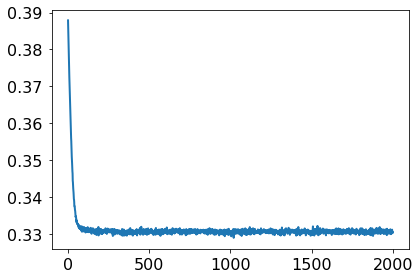

In [302]:
kron = KronGen(G_adj=adj_undirected_torch, k=7, dim_Theta1=2, seed=123)
loss_history = kron.train(Ntrain=2000, Npermutations=500, lr=1e-2)
plt.plot(loss_history)
#plt.xscale('log')
plt.show()

In [303]:
G_target = nx.from_numpy_matrix(kron.G_adj.numpy())
G_kron = nx.from_numpy_matrix(kron.sample_stochastic_mat(kron.generate_Pk().detach().numpy()))

print('number of nodes: %i %i' %(G_target.number_of_nodes(), G_kron.number_of_nodes()))
print('number of edges: %i %i' %(G_target.number_of_edges(), G_kron.number_of_edges()))
print('average clustering coefficient: %.2f %.2f' %(nx.average_clustering(G_target), nx.average_clustering(G_kron)))
print('number of triangles: %.2f %.2f' %(len(nx.triangles(G_target))/3, len(nx.triangles(G_kron))/3))
print('transitivity: %.2f %.2f' %(nx.transitivity(G_target), nx.transitivity(G_kron)))

number of nodes: 128 128
number of edges: 841 164
average clustering coefficient: 0.48 0.01
number of triangles: 42.67 42.67
transitivity: 0.36 0.01


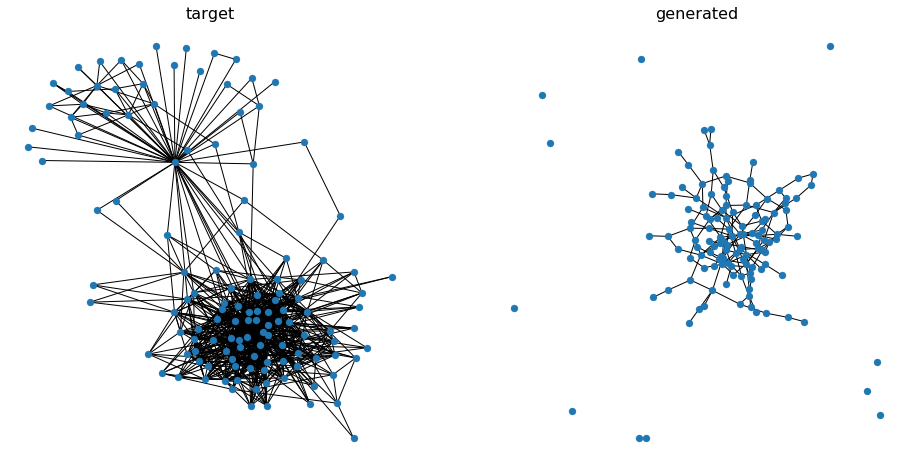

In [304]:
ss = 50
fs = 16

f, axs = plt.subplots(1, 2,figsize=(16,8))
plt.subplot(121)
nx.draw(G_target, node_size=ss)
plt.title('target', fontsize=fs)

plt.subplot(122)
nx.draw(G_kron, node_size=ss)#, width=10)
plt.title('generated', fontsize=fs)

#plt.savefig("four_grids.png")
plt.show()

To Do
- permutations
- how to deal with different dims for input/output
- how to handle enhanced graphs
- it would be nice to reproduce some of the general properties of stochastic graphs that the paper discusses
- code up graph comparison code (ERGM, GraphRNN, or myself...)

Done
- how to make sure P1 stays between [0,1]?
- how to make sure new graph is undirected